<a href="https://colab.research.google.com/github/datt16/MachineLearning/blob/main/INCT_ML10_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: Dogs vs Cats

※このファイルは香川高専（詫間キャンパス）で実施されたディープラーニング初級講座の内容を参考に作成しました。

Chapter 5, 6ではディープラーニングの最初の一歩として手書き数字の画像認識に取り組みました。ここからは，もう少し現実的な課題としてイヌとネコの画像を見分けるAIを作ってみましょう。イヌとネコそれぞれ12,500枚の画像データを使ってモデルを学習させます。モデルの形状や学習のパラメータを工夫して，高性能なイヌ・ネコ判別機を開発し，その精度（正解率）を向上させましょう。

このタスクはDogs vs Catsと呼ばれ，ネットで検索すると参考になる情報がたくさん見つかります。今回使用するデータセットは，データサイエンスコンペティションのサイトKaggleからダウンロードし少し加工したものです。Kaggleのサイトも非常に参考になります。

*    **Dogs vs Cats (Kaggle)**   https://www.kaggle.com/c/dogs-vs-cats

## データの準備

### ライブラリのインポート
必要なライブラリをインポートしましょう。

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# プログレスバーを表示するために使用
from tqdm import tqdm

import os
import random
import cv2
import time

# Google Colab上のTensorFlowは，もうすぐバージョン1.15から2.0に
# アップグレードされるらしいので，引き続き1.15を使用したい場合は，
# 次のマジックコマンドを使う。
%tensorflow_version 1.x 

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import plot_model

# trainX, trainYをさらに分離するために使用
from sklearn.model_selection import train_test_split

# 念のためTensorFlowのバージョンを確認
# 1.15.0と表示されればOK
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.15.2


### Googleドライブのマウント
いつものようにGoogleドライブをマウントし，ファイルにアクセスできるようにしてください。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### データセット（zipファイル）の解凍
今回使用するデータセットは，```dogs_vs_cats_dataset.zip```としてまとめてあります。以下のセルを実行してzipファイルを解凍してください。

In [ ]:
# !unzip "/content/drive/My Drive/INCT-ML/dogs_vs_cats_dataset.zip" > /dev/null 2>&1 &

今回のデータセットでは，学習用データは2つ（dogとcat）のディレクトリに，テスト用データは１つのディレクトリに入っています。

* **学習用データ（dog）**```/content/dogs_vs_cats_dataset/train/dog```
* **学習用データ（cat）**```/content/dogs_vs_cats_dataset/train/cat```
* **テスト用データ（分類無し）**```/content/dogs_vs_cats_dataset/test```

ディレクトリに入っているデータは全て画像なので，モデルを学習させるためには，MNISTのときのようなtrainX, trainYのデータを作る必要があります。

### 学習用データのファイル数とパスの確認
以下のセルを実行して学習用データのパスのリストを生成します。

In [ ]:
# 学習用データのパスを集めるための空のリストを作成
train_filepath_list = []

# catの学習用データが入っているディレクトリを指定
data_dir= "/content/dogs_vs_cats_dataset/train/cat"

# catの学習用データのパスを収集
filename_list = os.listdir(data_dir)
for filename in filename_list:
    filepath = os.path.join(data_dir, filename)
    train_filepath_list.append(filepath)


# dogの学習用データが入っているディレクトリの指定
data_dir= "/content/dogs_vs_cats_dataset/train/dog"

# dogの学習用データのパスを収集
filename_list = os.listdir(data_dir)
for filename in filename_list:
    filepath = os.path.join(data_dir, filename)
    train_filepath_list.append(filepath)

# 学習用データのパスのリストをシャッフル
random.seed(10)
random.shuffle(train_filepath_list)

# 学習用データの数の確認, 25000になっていることを確認
print("学習用データの数:", len(train_filepath_list))

# 学習データのパスの一部を表示して確認
print("最初の15個のパス")
train_filepath_list[:15]

学習用データの数: 25000
最初の15個のパス


['/content/dogs_vs_cats_dataset/train/cat/cat_09064.jpg',
 '/content/dogs_vs_cats_dataset/train/cat/cat_03060.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_12341.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_05532.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_04753.jpg',
 '/content/dogs_vs_cats_dataset/train/cat/cat_00101.jpg',
 '/content/dogs_vs_cats_dataset/train/cat/cat_09690.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_12237.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_02643.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_03245.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_11570.jpg',
 '/content/dogs_vs_cats_dataset/train/cat/cat_03872.jpg',
 '/content/dogs_vs_cats_dataset/train/dog/dog_07115.jpg',
 '/content/dogs_vs_cats_dataset/train/cat/cat_04551.jpg',
 '/content/dogs_vs_cats_dataset/train/cat/cat_05172.jpg']

### 学習用データの確認
学習用データにどんな画像が入っているのか一部を確認してみましょう。それぞれの画像のタイトルに，ファイル名と画像サイズを示しています。MNISTのときとは異なり，画像サイズや縦横比がそろっていないことが分かります。

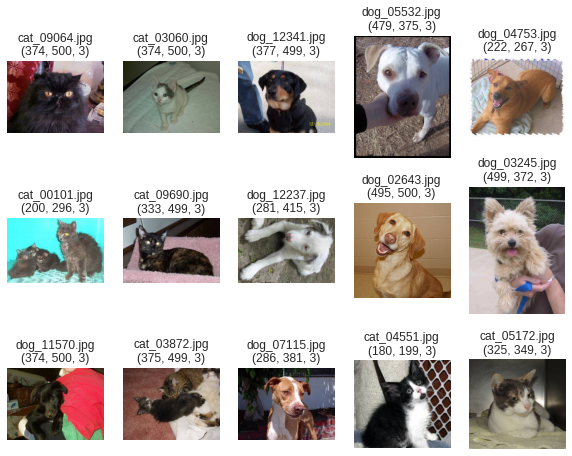

In [ ]:
plt.figure(figsize=(10,8))

# 最初の15個のデータを表示
for i in range(15):
    filepath = train_filepath_list[i]
    filename = os.path.basename(filepath)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    title = "{}\n{}".format(filename, img.shape)
    plt.title(title)
    plt.axis("off")

### trainX, trainYの生成
上記したように，もともとの画像データはサイズがそろっていません。しかし，Chapter 6で見たように，モデルに入力するためには全て同じサイズである必要があります。以下のコードを実行することで，画像のサイズをそろえながら，trainX, trainYを生成します。

**(注意)** ```newsize=(100, 100)```というところで新しい画像のサイズを指定しています。このサイズを大きくしすぎるとメモリ不足（Out of Memory, OOM）のエラーが発生することがあります。OOMが発生した時は，```newsize=(height, width)```を少し小さくして```ランタイムを出荷時設定にリセット```してノートブックの最初から実行しなおしてください。

In [ ]:
# trainX, trainYの空の配列を作成
trainX = []
trainY = []

# 変更後の画像サイズを指定
# (100, 100)より大きくするとOOMが発生する可能性あり
newsize = (87, 87)

# train_filepath_listの順番に画像を読み込み
print("学習用データの読み込み")
time.sleep(0.2)

for filepath in tqdm(train_filepath_list):

    # trainXにサイズ修正後の画像データを追加
    img = cv2.imread(filepath)
    img = cv2.resize(img, newsize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    trainX.append(img)

    # ファイル名からdog or catを判別し
    # dogなら1をcatなら0をtrainYに追加
    filename = os.path.basename(filepath)
    label = filename.split("_")[0]
    if label == "dog":
        trainY.append(1)
    elif label == "cat":
        trainY.append(0)


# trainXをnumpy配列に変換し，データの最大値が1.0になるように規格化
print("trainXを変換")
trainX = np.array(trainX)/255

# trainYをnumpy配列に変換し，さらにOne-hotベクトルに変換
print("trainYを変換")
trainY = to_categorical(np.array(trainY))

# trainXとtrainYのデータの形を確認
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)

print("完了")

学習用データの読み込み


100%|██████████| 25000/25000 [01:00<00:00, 414.39it/s]


trainXを変換
trainYを変換
trainX shape: (25000, 87, 87, 3)
trainY shape: (25000, 2)
完了


### trainX, trainYの確認
生成したtrainX, trainYの一部を表示して確認してみましょう。それぞれの画像のタイトルに，trainYのone-hotベクトルとデータのサイズを示しています。one-hotベクトルが正しいことと画像サイズがそろっていることを確認してください。

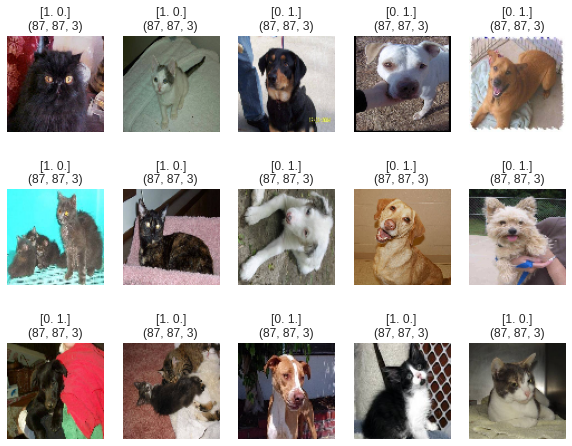

In [ ]:
plt.figure(figsize=(10,8))

# 最初の15個のデータを表示
for i in range(15):
    img = trainX[i]
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    title ="{}\n{}".format(trainY[i], img.shape)
    plt.title(title)
    plt.axis("off")

### テスト用データのファイル数とパスの確認
学習用データと同様にテスト用データについても処理を行う必要があります。以下のセルを実行してテスト用データのパスのリストを生成します。

In [ ]:
# テスト用データのパスを集めるための空のリストを作成
test_filepath_list = []

# テスト用データが入っているディレクトリを指定
data_dir= "/content/dogs_vs_cats_dataset/test"

# テスト用データのパスを収集
filename_list = os.listdir(data_dir)
for filename in filename_list:
    filepath = os.path.join(data_dir, filename)
    test_filepath_list.append(filepath)

# テスト用データのパスのリストをソート
# 今回はシャッフルしない！
# シャッフルするとコンペで正しく採点できない
test_filepath_list.sort()

# テスト用データの数とパスのリストの一部を表示
print("テスト用データの数:", len(test_filepath_list))
print("最初の15個のパス")
test_filepath_list[:15]

テスト用データの数: 1000
最初の15個のパス


['/content/dogs_vs_cats_dataset/test/test_00000.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00001.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00002.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00003.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00004.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00005.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00006.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00007.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00008.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00009.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00010.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00011.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00012.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00013.jpg',
 '/content/dogs_vs_cats_dataset/test/test_00014.jpg']

### テスト用データの確認
テスト用データにどんな画像が入っているのか一部を確認してみましょう。それぞれの画像のタイトルに，ファイル名とデータのサイズを示しています。学習用データと同じように，画像サイズや縦横比がそろっていないことが分かります。

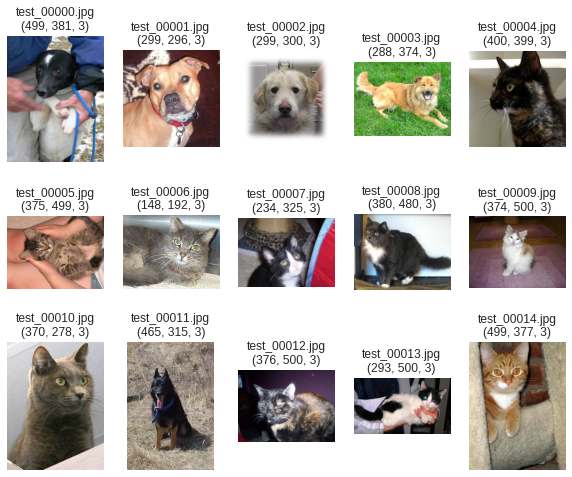

In [ ]:
plt.figure(figsize=(10,8))

# 最初の15個のデータを表示
for i in range(15):
    filepath = test_filepath_list[i]
    filename = os.path.basename(filepath)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    title = "{}\n{}".format(filename, img.shape)
    plt.title(title)
    plt.axis("off")

### testXの生成
テスト用のデータも，学習用のデータと同様にtestXを生成する必要があります。ちなみに今回はコンペなのでtestY（正解値）はありません。

In [ ]:
# testXの空の配列を作成
testX = []

# test_filepath_listの順番に画像を読み込み
print("テスト用データの読み込み")
time.sleep(0.2)
for filepath in tqdm(test_filepath_list):

    # testXにサイズ修正後の画像データを追加
    img = cv2.imread(filepath)
    img = cv2.resize(img, newsize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    testX.append(img)

# trainXをnumpy配列に変換し，データの最大値が1.0になるように規格化
print("testXを変換")
testX = np.array(testX)/255

# trainXとtestYのデータの形を確認
print("testX shape:", testX.shape)

print("完了")

テスト用データの読み込み


100%|██████████| 1000/1000 [00:02<00:00, 480.03it/s]

testXを変換
testX shape: (1000, 87, 87, 3)
完了


### testXの確認
生成したtestXの一部を表示して確認してみましょう。それぞれの画像のタイトルに，testXの画像サイズを示しています。画像サイズがそろっていることを確認してください。

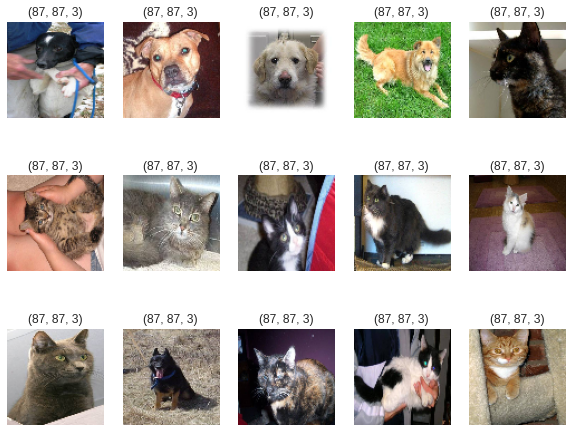

In [ ]:
plt.figure(figsize=(10,8))

# 最初の15個のデータを表示
for i in range(15):
    img = testX[i]
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    title ="{}".format(img.shape)
    plt.title(title)
    plt.axis("off")

### validX, validYを生成
trainX, trainYを分離して検証用データ（validX, validY）を生成します。```test_size=0.2```とすれば，trainX, trainYの2割を検証用データとして使用することになります。

In [ ]:
trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.2)

### すべてのデータのshapeを確認
もう一度，念のためtrainX, trainY, validX, validY, testXのshapeを確認しておきましょう。

In [ ]:
# 念のため，trainX, trainY, testXのshapeを確認
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("validX shape:", validX.shape)
print("validY shape:", validY.shape)
print("testX shape:", testX.shape)

trainX shape: (20000, 87, 87, 3)
trainY shape: (20000, 2)
validX shape: (5000, 87, 87, 3)
validY shape: (5000, 2)
testX shape: (1000, 87, 87, 3)


## 学習
モデルを構築し学習させていきます。trainX, trainYをChapter 6 (MNIST)と同じ形式にそろえたので，基本的に同じ方法で学習できます。

### モデルの構築
まずはモデルを構築します。デフォルトで記載されているのはChapter 6と同じモデルですが，入力層のinput_shapeと出力層のノードの数だけ，今回のタスクに合わせて変更してあります。

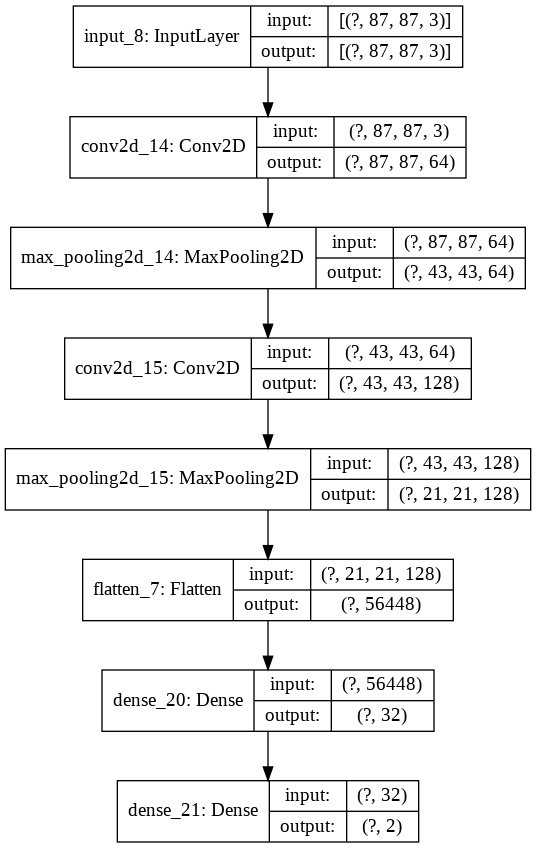

In [ ]:
# モデルの初期化
model = Sequential()

# 入力層
model.add(InputLayer(input_shape=trainX.shape[1:]))

# 中間層（１層目），畳み込み層
model.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))

# 中間層（2層目）プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 中間層（3層目），畳み込み層
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))

# 中間層（4層目），プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 中間層（5層目）, ここで二次元配列を一次元配列に変更
model.add(Flatten())

# 中間層（6層目），全結合層
model.add(Dense(32, activation="relu"))


# Dropout層
#model.add(Dropout(0.3))

# 出力層，全結合層
model.add(Dense(trainY.shape[1], activation="softmax"))

# 構築したモデルを可視化して確認
plot_model(model, show_shapes=True)

構築したモデルは次の方法でも確認できます。この方法では，学習させるパラメータの数を確認することもできます。

In [ ]:
# 構築したモデルを別の方法で可視化して確認
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 87, 87, 64)        1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 43, 43, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 56448)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1806368   
_________________________________________________________________
dense_21 (Dense)             (None, 2)                

### モデルのコンパイル

モデルを学習させるためにコンパイルします。指定する主なパラメータは以下の通りです。

* **loss** 損失関数は何を使うか？分類問題の場合は，"categorical_crossentropy"がほとんど。これをもとにパラメータの最適化が行われる。
* **optimizer** 最適化関数は何を使うか？"adam"のほかに，"sgd", "RMSprop"などが使える
* **metrics** 評価関数。パラメータの最適化には用いられない。

In [ ]:
# モデルをコンパイルする
model.compile(
                loss="categorical_crossentropy", 
                optimizer="adam",
                metrics=["accuracy"]
            )


# 最適化関数の例
# optimizer = "adam"
# optimizer = Adam(learning_rate = 1E-5)
# optimizer = "sgd"
# optimizer = SGD(learning_rate = 1E-5)
# optimizer = "RMSprop"

### モデルの学習（トレーニング）

モデルを学習させます。```model.fit()```だけでも学習できますが，```history=model.fit()```としておくことで後から学習経過を可視化できます。指定する主なパラメータは以下の通りです。

* **trainX** 学習用データの入力データ
* **trainY** 学習用データの出力データ
* **batch_size** 何個のデータごとにパラメータを更新するか？1バッチあたりのデータ数
* **epochs** すべての学習用データを何回通りみるか？
* **validation_data** 検証用データ。
* **shuffle** 学習用データを見る順番をシャッフルするか？
* **callbacks(EarlyStopping)** val_lossが上がり始めたら早めに学習を止める
* **verbose** 学習経過の表示方法。0,1,2が選択可能。

In [ ]:
history = model.fit(
                    trainX, trainY,
                    batch_size=400,
                    epochs=20,
                    validation_data=(validX, validY),
                    shuffle=True,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
                    verbose=1
                   )

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 11s 566us/sample - loss: 0.7475 - acc: 0.5411 - val_loss: 0.6643 - val_acc: 0.6438
Epoch 2/20
20000/20000 [==============================] - 11s 552us/sample - loss: 0.6294 - acc: 0.6699 - val_loss: 0.6025 - val_acc: 0.6858
Epoch 3/20
20000/20000 [==============================] - 11s 553us/sample - loss: 0.5919 - acc: 0.7229 - val_loss: 0.5715 - val_acc: 0.7466
Epoch 4/20
20000/20000 [==============================] - 11s 552us/sample - loss: 0.5636 - acc: 0.7498 - val_loss: 0.5519 - val_acc: 0.7460
Epoch 5/20
20000/20000 [==============================] - 11s 551us/sample - loss: 0.5379 - acc: 0.7673 - val_loss: 0.5381 - val_acc: 0.7638
Epoch 6/20
20000/20000 [==============================] - 11s 551us/sample - loss: 0.5086 - acc: 0.7883 - val_loss: 0.5371 - val_acc: 0.7598
Epoch 7/20
20000/20000 [==============================] - 11s 551us/sample - loss: 0.4882 - acc: 0.8001 -

### 学習経過の確認
学習経過を可視化して上手く学習できているか，過学習などが起こっていないかを確認しましょう。

Text(0, 0.5, 'Accuracy & Loss')

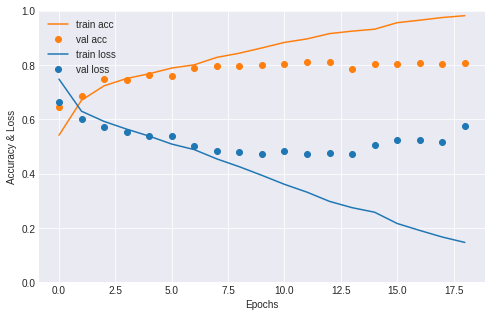

In [ ]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,5))

epoch = history.epoch
train_acc = history.history["acc"]
train_loss = history.history["loss"]
val_acc = history.history["val_acc"]
val_loss = history.history["val_loss"]

plt.plot(epoch, train_acc, label="train acc", c="#ff7f0e")
plt.plot(epoch, val_acc, marker="o", lw=0, label="val acc", c="#ff7f0e")

plt.plot(epoch, train_loss, label="train loss", c="#1f77b4")
plt.plot(epoch, val_loss, marker="o", lw=0, label="val loss", c="#1f77b4")

plt.ylim(0, 1)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

### 学習済みモデルの保存
次のセルを実行して学習済みのモデルを保存しておきましょう。この後のChapterで使用します。

In [ ]:
path = "/content/drive/My Drive/INCT-ML/dogs_vs_cats_model.h5"
model.save(path)

## 推論 

### テスト用データ（testX）からイヌまたはネコを推論
学習済みモデルを使ってテスト用データに対して推論を行います。

In [ ]:
# 推論
predY = model.predict(testX)

### 推論結果の一部を表示
推論結果の一部を表示して確認してみましょう。catまたはdogである確率が表示されています。

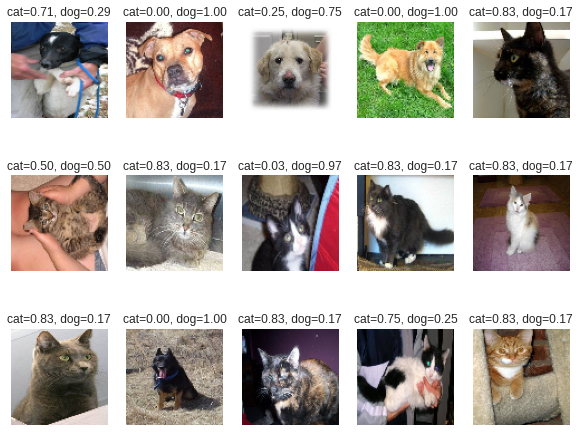

In [ ]:
plt.figure(figsize=(10,8))
for i in range(15):
    img = testX[i]
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title("cat={:.2f}, dog={:.2f}".format(predY[i,0], predY[i,1]))
    plt.axis("off")

## 答え合わせ
事前にアップロードしたファイル: dogs_vs_cats_testY_1k.csv にテスト用データ1000枚に対する正解値（cat=0, dog=1）が記載されています。このファイルを読み込み答え合わせをします。

In [ ]:
path = "/content/drive/My Drive/INCT-ML/dogs_vs_cats_testY_1k.csv"
testY = pd.read_csv(path)["label"]
testY = to_categorical(np.array(testY))
score = model.evaluate(testX, testY)
print("Test Accuracy = {:.3f}".format(score[1]))

1000/1000 [==============================] - 0s 298us/sample - loss: 0.6841 - acc: 0.7890
Test Accuracy = 0.789
